In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Set the random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Parameters for the linear model
n_samples = 1024*2
input_dim = 10  # Change this to control the dimensionality of the input
noise_std = 0.1
num_epochs = 300

true_weights = np.random.randn(input_dim, 1)
true_intercept = np.random.rand(1)

In [2]:
true_weights, true_intercept

(array([[ 0.49671415],
        [-0.1382643 ],
        [ 0.64768854],
        [ 1.52302986],
        [-0.23415337],
        [-0.23413696],
        [ 1.57921282],
        [ 0.76743473],
        [-0.46947439],
        [ 0.54256004]]),
 array([0.18182497]))

In [3]:
truth = np.append(true_weights.reshape(-1), true_intercept)

In [4]:
# Generate random x values
X = np.random.rand(n_samples, input_dim)
X[:, -1][np.where(X[:, -1]>0.5)]=1
X[:, -1][np.where(X[:, -1]<0.5)]=0

# Generate y values based on the linear model with Gaussian noise
y = X @ true_weights + true_intercept + np.random.randn(n_samples, 1) * noise_std

# Create Date loader
dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32),torch.tensor(y, dtype=torch.float32))


In [5]:
# Define the linear regression model
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)  # Input dimension is input_dim, output dimension

    def forward(self, x):
        return self.linear(x)

In [6]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# FL i.i.d senario

In [7]:
import random
def test_FL(batch_size, seed=1234):
    dataset1 = torch.utils.data.TensorDataset(torch.tensor(X[:int(len(y)/2)], dtype=torch.float32),torch.tensor(y[:int(len(y)/2)], dtype=torch.float32))
    dataset2 = torch.utils.data.TensorDataset(torch.tensor(X[int(len(y)/2):], dtype=torch.float32),torch.tensor(y[int(len(y)/2):], dtype=torch.float32))
    #dataset1 = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32),torch.tensor(y, dtype=torch.float32))
    #dataset2 = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32),torch.tensor(y, dtype=torch.float32))
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    g = torch.Generator()
    g.manual_seed(seed)
    # Initialize the model, loss function, and optimizer
    number_local_steps = len(X)/batch_size
    learning_rate = 0.05/number_local_steps
    loader1 = torch.utils.data.DataLoader(dataset1, batch_size=batch_size, generator=g)
    loader2 = torch.utils.data.DataLoader(dataset2, batch_size=batch_size, generator=g)
    model1 = LinearRegressionModel(input_dim,1)
    model2 = LinearRegressionModel(input_dim,1)
    criterion = nn.MSELoss()
    optimizer1 = optim.SGD(model1.parameters(), lr=learning_rate)
    optimizer2 = optim.SGD(model2.parameters(), lr=learning_rate)

    # Lists to store gradients and parameters
    gradients1 = []
    gradients2 = []
    parameters = []

    with torch.no_grad():
        for paramA, paramB in zip(model1.parameters(), model2.parameters()):
            paramA.copy_(paramB)
    # Train the model

    for epoch in range(num_epochs):
        # Register Global model
        current_parameters = []
        for param in model1.parameters():
            if param.requires_grad:
                current_parameters.append(param.view(-1).detach())
        global_model = torch.cat(current_parameters).numpy()
        parameters.append(global_model)
        #print(torch.cat(current_parameters).numpy())
        for X_tensor, y_tensor in loader1:
            # Forward pass: compute the model output
            outputs = model1(X_tensor)
            loss = criterion(outputs, y_tensor)

            # Backward pass and optimization
            optimizer1.zero_grad()
            loss.backward()
            optimizer1.step()

                # Register output model
        current_output_model = []
        for param in model1.parameters():
            if param.requires_grad:
                current_output_model.append(param.view(-1).detach())
        local_model1 = torch.cat(current_output_model).numpy()

        for X_tensor, y_tensor in loader2:
            # Forward pass: compute the model output
            outputs = model2(X_tensor)
            loss = criterion(outputs, y_tensor)

            # Backward pass and optimization
            optimizer2.zero_grad()
            loss.backward()
            optimizer2.step()

        # Register output model
        current_output_model = []
        for param in model2.parameters():
            if param.requires_grad:
                current_output_model.append(param.view(-1).detach())
        local_model2 = torch.cat(current_output_model).numpy()

        # Average parameters:
        with torch.no_grad():
            for param1, param2 in zip(model1.parameters(), model2.parameters()):
                temp = param1.data.detach().clone()
                param1.data = (temp+param2.data)/2
                param2.data = (temp+param2.data)/2


        #print(local_model)
        #print(global_model-local_model)


        gradients1.append(global_model-local_model1)
        gradients2.append(global_model-local_model2)

        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    norm_distance1, loss_distance_1, acc1 = evaluate_attack(gradients1, parameters)
    norm_distance2, loss_distance_2, acc2 = evaluate_attack(gradients2, parameters)
    print(f"Client 1 {norm_distance1}, {loss_distance_1}, {acc1}")
    print(f"Client 2 {norm_distance2}, {loss_distance_2}, {acc2}")
    #return norm_distance1, loss_distance_1, acc1
    return (norm_distance1+norm_distance2)/2, (loss_distance_1+loss_distance_2)/2, (acc1+acc2)/2


In [8]:
def evaluate_attack(gradients, parameters):
    gradients = np.array(gradients)  # Theta out
    parameters = np.array(parameters)  # Theta in
    Theta_out = np.c_[ gradients, np.ones(len(gradients)) ]
    Theta_in = parameters
    rounds_index = [i*20 for i in range(12)]
    Theta_out_cal = Theta_out[rounds_index]
    Theta_in_cal = Theta_in[rounds_index]
    result = np.linalg.inv(Theta_out_cal)@Theta_in_cal #Only 12 messages which makes the matrix to be square that the calculation can be simplified. Otherwise, we will have a extremely ill-condidtioned matrix to invert
    norm_distance = np.linalg.norm(truth-result[-1])
    loss_distance = np.linalg.norm(X @ result[-1][:-1] + result[-1][-1] - y[:,0])**2/len(X)

    s = (y[:,0] - X[:, :-1] @ result[-1][:-2] - result[-1][-1])/result[-1][-2]
    s[np.where(s<0.5)] = 0
    s[np.where(s>=0.5)] = 1
    acc = sum(1-abs(s-X[:,-1]))/y[:,0].size

    return norm_distance, loss_distance, acc

In [9]:
test_FL(32, seed=0)

Epoch [100/300], Loss: 0.2251
Epoch [200/300], Loss: 0.1084
Epoch [300/300], Loss: 0.0557
Client 1 0.4096617078112583, 0.024717720614365828, 0.984375
Client 2 1.3943527395314497, 0.06346460624445653, 0.8515625


(0.902007223671354, 0.044091163429411176, 0.91796875)

In [10]:
norm_distance = []
loss_distance = []
accs = []
seed = 5
batch_sizes = [64, 256, 1024]
for batch in batch_sizes:
    print("--------------------------------------")
    print(batch)
    norm_distance.append([])
    loss_distance.append([])
    accs.append([])
    for i in range(seed):
        norm, loss, acc = test_FL(batch, i)
        norm_distance[-1].append(norm)
        loss_distance[-1].append(loss)
        accs[-1].append(acc)

--------------------------------------
64
Epoch [100/300], Loss: 0.1743
Epoch [200/300], Loss: 0.0865
Epoch [300/300], Loss: 0.0464
Client 1 0.5459794740369763, 0.022911547177039075, 0.97900390625
Client 2 0.13388525644956234, 0.010550760458838598, 0.99560546875
Epoch [100/300], Loss: 0.1885
Epoch [200/300], Loss: 0.0881
Epoch [300/300], Loss: 0.0450
Client 1 0.21731709767245777, 0.011759891461972417, 0.9951171875
Client 2 0.10962407921023655, 0.010281931210560268, 0.99560546875
Epoch [100/300], Loss: 0.2295
Epoch [200/300], Loss: 0.1018
Epoch [300/300], Loss: 0.0499
Client 1 0.23297232530651749, 0.011729946130384902, 0.9951171875
Client 2 0.30747355189072556, 0.014108626167790812, 0.9931640625
Epoch [100/300], Loss: 0.1682
Epoch [200/300], Loss: 0.0816
Epoch [300/300], Loss: 0.0426
Client 1 3.8855795716032944, 0.4191881204883395, 0.66162109375
Client 2 1.2034727594955548, 0.13888148896816443, 0.80078125
Epoch [100/300], Loss: 0.2172
Epoch [200/300], Loss: 0.1012
Epoch [300/300], Loss:

Text(0.5, 0, 'Batch size $B$')

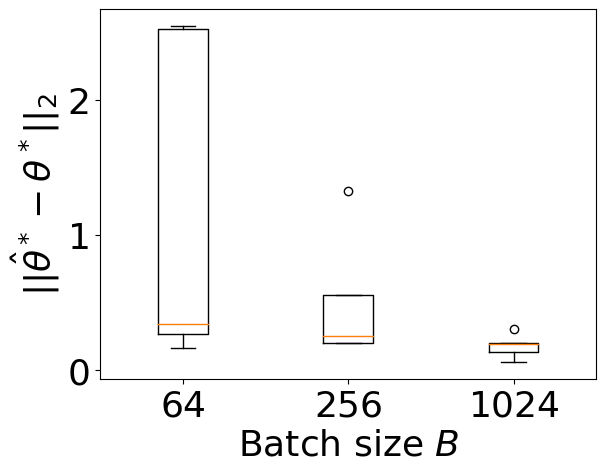

In [11]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc


plt.rcParams.update({'font.size': 26})
rc('font', **{'family': 'sans-serif', 'serif': ['Computer Modern']})
plt.rcParams['axes.facecolor'] = 'xkcd:white'
plt.rcParams['axes.edgecolor'] = 'black'
# plt.rcParams['figure.figsize'] = 6.4, 4.8
plt.boxplot(norm_distance, meanline=True)
labels = [f'${i}$' for i in batch_sizes]
plt.xticks([1, 2, 3], labels)
plt.ylabel(r"$||\hat{\theta}^* - \theta^*||_2$")
plt.xlabel(r"Batch size $B$")

([<matplotlib.axis.XTick at 0x7fa43c207d90>,
 [Text(0.0, 0, '$64$'), Text(1.0, 0, '$256$'), Text(2.0, 0, '$1024$')])

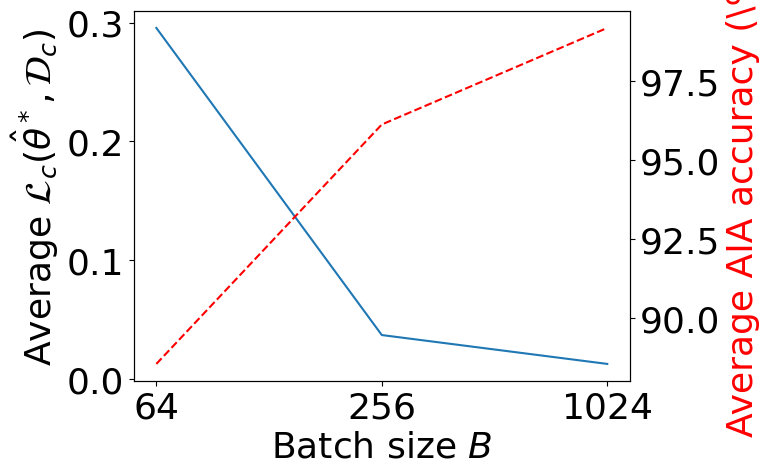

In [12]:
# matplotlib.rcParams.update({'font.size': 26})
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(labels, [sum(loss_distance[i])/seed for i in range(len(loss_distance))])
ax2.plot(labels, [sum(accs[i])/seed*100 for i in range(len(accs))], "--", color="red")
ax1.set_ylabel(r"Average $ \mathcal{L}_c(\hat{\theta}^*, \mathcal{D}_c)$")
ax2.set_ylabel(r"Average AIA accuracy (\%)")
#ax2.tick_params(axis='y', colors='red')
ax2.yaxis.label.set_color('red')
ax1.set_xlabel(r"Batch size $B$")
# plt.xscale("log", base=2)
plt.xticks(labels)

Text(0.5, 0, 'Batch size $B$')

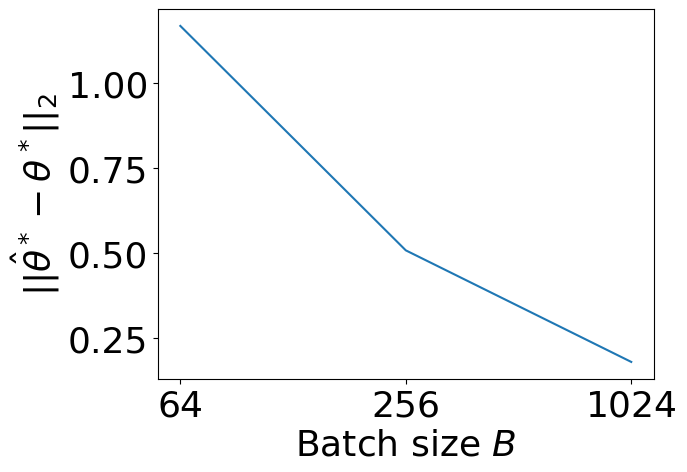

In [13]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 26})
plt.plot(labels, [sum(norm_distance[i])/seed for i in range(len(norm_distance))])
plt.ylabel(r"$||\hat{\theta}^* - \theta^*||_2$")
plt.xlabel(r"Batch size $B$")
# plt.xscale("log", base=2)